# LDA Model - Added New Metrics 
Update: 04.05.2021<br>
Mai Vu

In [3]:
#Basic libraries
import random
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Libraries for (dynamic) topic modeling
import gensim
from gensim import corpora
import pprint
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import ldaseqmodel
from gensim.test.utils import datapath

#For plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import plotly.graph_objs as go
import plotly.express as ex
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected = True)
init_notebook_mode(connected = True)

# 1. Init steps

In [4]:
#Read the data
eng_data = pd.read_csv('eng_abstracts_full.csv')

In [5]:
#Create eng_stopwords set and lemmatizer from NLTK library
eng_stopwords = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
lemmatizer = WordNetLemmatizer()

In [6]:
def CalculateCoherenceRange(texts, bow, dictionary, start = 1, end = 20):
    """Function to calculate the coherence scores of different LDA models with the number of topics in the given range.
    Abstracts are divided into smaller subsets so that the coherence curve will be smoother.
    
    Args:
        (list) texts: abstracts in text.
        (list) bow: bag of words of abstracts.
        (Dictionary) dictionary: a mapping between words in texts and their integer ids.
        (integers) start, end: number of topics' range.

    Returns:
        (lists) u_mass, c_v, c_uci, c_npmi: coherence scores of different LDA models with the number of topics in the given range.
    """
    u_mass = []
    c_v = []
    c_uci = []
    c_npmi = []
    n = len(bow)
    
    for num_topic in range(start, end + 1):
        np.random.seed(111)
        u_mass_temp = []
        c_v_temp = []
        c_uci_temp = []
        c_npmi_temp = []
        
        for i in range(10):
            index = np.random.choice(n, int(0.80 * n))
            t = [texts[x] for x in index]
            c = [bow[x] for x in index]
            LDA_model = LdaModel(c, num_topics = num_topic, id2word = dictionary, passes = 10, random_state = 111)
            
            #u_mass
            temp = CoherenceModel(model = LDA_model, texts = t, corpus = c, dictionary = dictionary, coherence = 'u_mass')
            u_mass_temp.append(temp.get_coherence())
            #c_v
            temp = CoherenceModel(model = LDA_model, texts = t, corpus = c, dictionary = dictionary, coherence = 'c_v')
            c_v_temp.append(temp.get_coherence())
            #c_uci
            temp = CoherenceModel(model = LDA_model, texts = t, corpus = c, dictionary = dictionary, coherence = 'c_uci')
            c_uci_temp.append(temp.get_coherence())
            #c_npmi
            temp = CoherenceModel(model = LDA_model, texts = t, corpus = c, dictionary = dictionary, coherence = 'c_npmi')
            c_npmi_temp.append(temp.get_coherence())
            
        u_mass.append(np.mean(u_mass_temp))
        c_v.append(np.mean(c_v_temp))
        c_uci.append(np.mean(c_uci_temp))
        c_npmi.append(np.mean(c_npmi_temp))
        print('.', end = " ")
        
    print()
    return u_mass, c_v, c_uci, c_npmi

In [7]:
def CalculateCoherence(LDA_model, texts, bow, dictionary):
    """Function to calculate the coherence scores of a LDA model.
    
    Args:
        (LdaModel) LDA_model: the given LDA model.
        (list) texts: abstracts in text.
        (list) bow: bag of words of abstracts.
        (Dictionary) dictionary: a mapping between words in texts and their integer ids.

    Returns:
        (floats) u_mass, c_v, c_uci, c_npmi: coherence scores of the given LDA model.
    """
    #u_mass
    temp = CoherenceModel(model = LDA_model, texts = texts, corpus = bow, dictionary = dictionary, coherence = 'u_mass')
    u_mass = temp.get_coherence()
    #c_v
    temp = CoherenceModel(model = LDA_model, texts = texts, corpus = bow, dictionary = dictionary, coherence = 'c_v')
    c_v = temp.get_coherence()
    #c_uci
    temp = CoherenceModel(model = LDA_model, texts = texts, corpus = bow, dictionary = dictionary, coherence = 'c_uci')
    c_uci = temp.get_coherence()
    #c_npmi
    temp = CoherenceModel(model = LDA_model, texts = texts, corpus = bow, dictionary = dictionary, coherence = 'c_npmi')
    c_npmi = temp.get_coherence()

    return u_mass, c_v, c_uci, c_npmi

In [8]:
def PlotKeywords(LDA_model, num_topic, num_word = 8):
    """Function to plot important keywords.
    
    Args:
        (LdaModel) LDA_model: the given LDA model.
        (integer) num_topic: number of topics of the model.
        (integer) num_word: number of words to plot.

    Returns:
        None.
    """
    keywords = [[word for word, _ in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]
    keywords_prob = [[beta for _, beta in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]

    gs = gridspec.GridSpec(round(math.sqrt(num_topic)) + 1, round(math.sqrt(num_topic)) + 1)
    gs.update(wspace = 0.5, hspace = 0.5)
    plt.figure(figsize = (20, 15))
    for i in range(num_topic):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_word), keywords_prob[i][:num_word])
        ax.invert_yaxis()
        ax.set_yticks(range(num_word))
        ax.set_yticklabels(keywords[i][:num_word])
        plt.grid()
        plt.title("Topic " + str(i + 1))

In [9]:
def PlotCoherenceScores(u_mass, c_v, c_uci, c_npmi):
    """Function to plot coherence scores using Plotly.
    
    Args:
        (lists) u_mass, c_v, c_uci, c_npmi: coherence scores of different LDA models with the number of topics.

    Returns:
        None.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = list(range(1, len(u_mass) + 1)), y = u_mass, mode = 'lines + markers', name = 'u_mass'))
    fig.add_trace(go.Scatter(x = list(range(1, len(c_v) + 1)), y = c_v, mode = 'lines + markers', name = 'c_v'))
    fig.add_trace(go.Scatter(x = list(range(1, len(c_uci) + 1)), y = c_uci, mode = 'lines + markers', name = 'c_uci'))
    fig.add_trace(go.Scatter(x = list(range(1, len(c_npmi) + 1)), y = c_npmi, mode = 'lines + markers', name = 'c_npmi'))
    fig.update_layout(title = 'Plot Coherence Scores', xaxis_title = 'Number of topics', legend_title = 'Metrics', xaxis_dtick = 1)
    fig.show()

# 2. LDA Model

In [10]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
allwords_abstracts = []
for abstract in eng_data['abstract_en']:
    tokens = []
    for token in nltk.word_tokenize(abstract):
        if token.upper() == token and token.isalpha() and len(token) > 1:
            tokens.append(token)
        else:
            token = token.lower()
            if token.isalpha() and token not in eng_stopwords and len(token) > 3:
                tokens.append(lemmatizer.lemmatize(token))
    allwords_abstracts.append(tokens)

print('- Finish preprocessing data (all words) in', round((time.time() - start_time)/60), 'min(s)')

- Finish preprocessing data (all words) in 1 min(s)


In [11]:
# Build the bigram
bigram = gensim.models.Phrases(allwords_abstracts, min_count = 10, threshold = 10)

In [12]:
for idx in range(len(allwords_abstracts)):
    allwords_abstracts[idx] = bigram[allwords_abstracts[idx]]

In [13]:
#Create dictionary for the given texts
allwords_dictionary = corpora.Dictionary(allwords_abstracts)
allwords_dictionary.filter_extremes(no_below = 10, no_above = 0.25) #Filter words that appear less than 10 documents and more than 25% of all documents
print(allwords_dictionary)

#Create the bag of words for all documents
allwords_bow = [allwords_dictionary.doc2bow(abstract) for abstract in allwords_abstracts]

Dictionary(7504 unique tokens: ['activity', 'actual', 'analyse_current', 'area', 'book']...)


## 2.1 Choose the number of topics

In [14]:
start_time = time.time() #Start count time
u_mass, c_v, c_uci, c_npmi = CalculateCoherenceRange(allwords_abstracts, allwords_bow, allwords_dictionary)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

#Plot the coherence plot
PlotCoherenceScores(u_mass, c_v, c_uci, c_npmi)

. . . . . . . . . . . . . . . . . . . . 
- Finish in 402 min(s)


## 2.2 LDA model with 8 topics

In [15]:
allwords_LDA_model = LdaModel(allwords_bow, num_topics = 8, id2word = allwords_dictionary, random_state = 111, passes = 30)

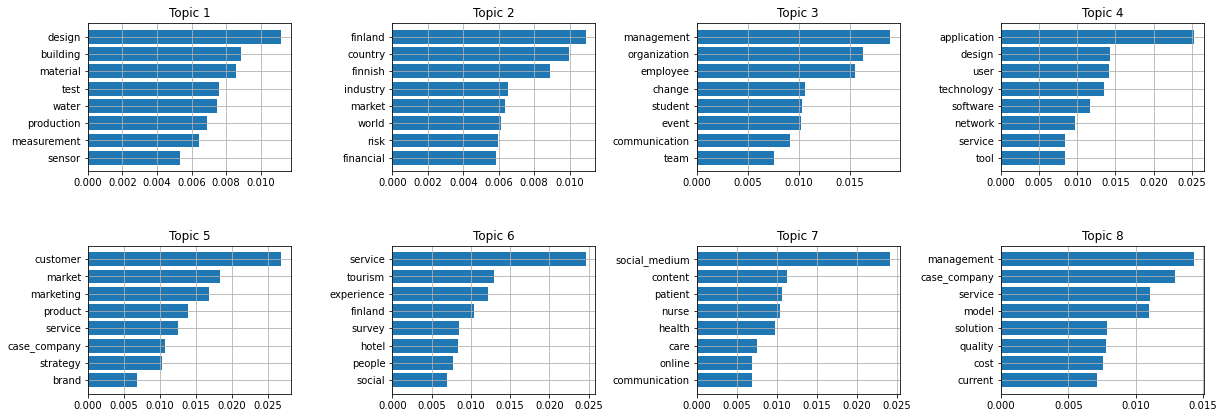

In [16]:
PlotKeywords(allwords_LDA_model, 8)

## 2.3 Plot topics

In [17]:
#Display the topics
allwords_display = gensimvis.prepare(allwords_LDA_model, allwords_bow, allwords_dictionary, sort_topics = False)
pyLDAvis.display(allwords_display)

## 2.4 Evaluate model

In [18]:
#Calculate Coherence Score
allwords_u_mass, allwords_c_v, allwords_c_uci, allwords_c_npmi = CalculateCoherence(allwords_LDA_model, 
                                                                                    allwords_abstracts, 
                                                                                    allwords_bow, allwords_dictionary)
print('u_mass =', round(allwords_u_mass, 3))
print('c_v    =', round(allwords_c_v, 3))
print('c_uci  =', round(allwords_c_uci, 3))
print('c_npmi =', round(allwords_c_npmi, 3))

u_mass = -2.472
c_v    = 0.443
c_uci  = 0.023
c_npmi = 0.026
